In [3]:
import numpy as np
import pandas as pd

## Passo 1: Leitura dos dados
Leitura dos bancos de dados em DataFrame Pandas. 

In [247]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [248]:
df = pd.read_csv(caminho_dados_lazaro)

In [249]:
df.head()

,Piquete,Altura real,Altura esperada,Animal,SensorID,Sensor Name,Date,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer,magn,sma,ent,pit,rol,icl
0,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:47,-0.132,-0.583,0.712,Ocio,0.0,1.0,0.0,0.929654,1.427,-0.005973,8.162915,129.311311,40.014999
1,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:48,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
2,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:50,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
3,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:51,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
4,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:52,-0.061,-0.870,0.478,Ocio,0.0,1.0,0.0,0.994538,1.409,-0.361029,3.516446,151.214493,61.273746


In [250]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

## Passo 2: Treinamento e Validação

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
# Para a busca do melhores hiperparêmetros
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

### Seleção de colunas aplicáveis

In [252]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

In [253]:
# Lista com os atributos aplicáveis
features_aplicaveis = ['X', 'Y' ,'Z', 'Comportamento', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']

# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [254]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
# Test size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

In [40]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y_pnp, train_size=0.8, random_state = 0)

In [255]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)
X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X_train.columns
index_train = X_train.index
index_test = X_test.index


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

X_train = pd.concat([X_train, X_train_season], axis=1)
X_test = pd.concat([X_test, X_test_season], axis=1)

### Função para imprimir e salvar matriz de confusão

In [256]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

### LGBMClassifier

In [89]:
from lightgbm import LGBMClassifier

In [43]:
lgb_model = LGBMClassifier(n_jobs=-1, random_state=0)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

77.83414312772791

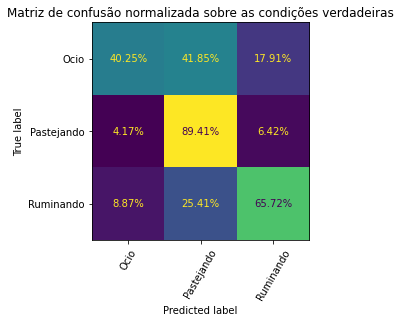

In [80]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

#### LGB: Busca de melhores hiper parâmetros

In [50]:
def tune_lgb(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    lgb_Model = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100, n_jobs=-1)
    
    auc = cross_val_score(lgb_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 512), # num_leaves
         (1, 500), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

In [51]:
%%time
resultados_lgb = gp_minimize(tune_lgb, space, random_state=0, verbose=1, n_calls=50, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 433, 429, 0.8548891518449193, 0.6612073271073752] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 29.7196
Function value obtained: -0.7125
Current minimum: -0.7125
Iteration No: 2 started. Evaluating function at random point.
[0.005871694001325899, 154, 29, 0.30902347985110756, 0.529898605589215] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.8425
Function value obtained: -0.6312
Current minimum: -0.7125
Iteration No: 3 started. Evaluating function at random point.
[0.04210536704211821, 247, 197, 0.8442748253605089, 0.40365654437554166] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.5394
Function value obtained: -0.7245
Current minimum: -0.7245
Iteration No: 4 started. Evaluating function at random point.
[0.01978535031094702, 190, 479, 0.1833332413920129, 0.8830785325225929] 

Iteration No: 4 ended. Evaluation done at random poi

In [52]:
resultados_lgb.x

[0.1, 512, 1, 1.0, 0.6446300002048094]

In [19]:
# Melhores hiper parâmetros para o conjunto PRO: learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

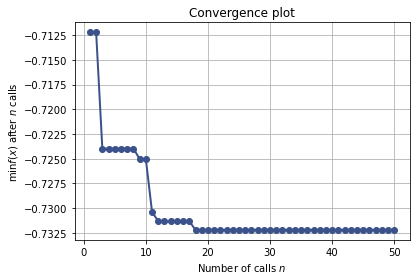

In [18]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

In [36]:
# Melhores hiper parâmetros para o conjunto PNP: learning_rate=0.1, num_leaves=512, min_child_samples=88, subsample=0.729, colsample_bytree=0.671, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

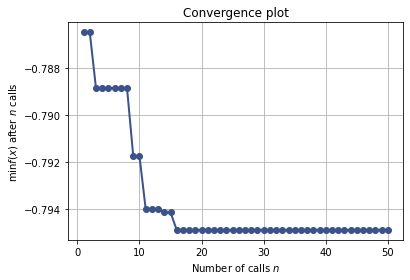

In [86]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

#### LGB: Treinamento com os melhores hiper parâmetros

In [90]:
%%time
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

CPU times: user 1min 3s, sys: 422 ms, total: 1min 3s
Wall time: 8.72 s


73.3846660627522

In [91]:
print(classification_report(y_test, lgb_preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.643     0.396     0.490     24652
  Pastejando      0.768     0.895     0.826     66502
   Ruminando      0.691     0.656     0.673     30276

    accuracy                          0.734    121430
   macro avg      0.701     0.649     0.663    121430
weighted avg      0.723     0.734     0.720    121430



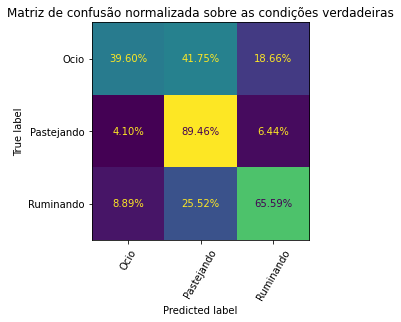

In [92]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

In [93]:
lgb_preds = lgb_model.predict(X_train)

accuracy_score(y_train, lgb_preds)*100

77.02009388124846

### Random Forest

In [257]:
from sklearn.ensemble import RandomForestClassifier

#### Com Randomized Search CV

In [39]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [40]:
# Create the param grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [41]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [ ]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [46]:
rf_RandomGrid.best_params_

{'n_estimators': 150,
 'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': False}

In [48]:
rf_RandomGrid.best_score_

0.7361747363918738

In [50]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [51]:
accuracy_score(y_test, preds_rf_RG)*100

74.09413128837589

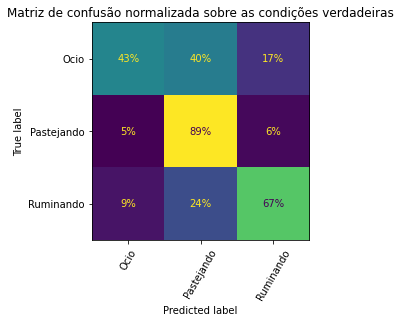

In [52]:
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

#### RF: Busca de melhores hiper parâmetros

In [92]:
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [93]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 118.0591
Function value obtained: -0.7941
Current minimum: -0.7941
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.4995
Function value obtained: -0.7960
Current minimum: -0.7960
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 78.5794
Function value obtained: -0.7949
Current minimum: -0.7960
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 85.1647
Function value obtained: -0.7974
Current minimum: -0.7974
Iteration No: 5 started. Evaluating function a

In [96]:
resultado_rf.x

[200, 'sqrt', 50, 'entropy', 30, 1, True]

In [63]:
# Melhores hiper parâmetros para o conjunto PRO: n_estimators=200, max_features='sqrt', max_depth=None, criterion='entropy', min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

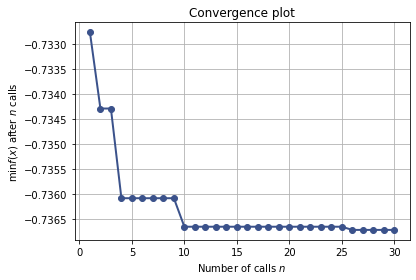

In [64]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [97]:
# Melhores hiper parâmetros para o conjunto PNP: n_estimators=200, max_features='sqrt', max_depth=50, criterion='entropy', min_samples_split=30, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

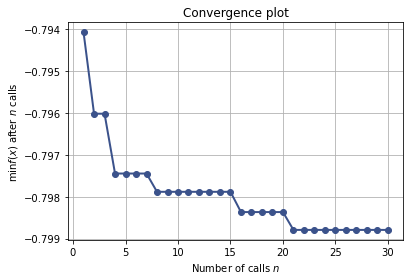

In [95]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

#### RF: Treinamento com os melhores hiper parâmetros

In [258]:
%%time
rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=None, criterion='entropy', min_samples_split=10,
                               min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 9min 8s, sys: 897 ms, total: 9min 9s
Wall time: 1min 12s


In [259]:
accuracy_score(y_test, preds)*100

74.15465700403526

In [260]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.648     0.440     0.524     24652
  Pastejando      0.776     0.889     0.829     66502
   Ruminando      0.704     0.663     0.683     30276

    accuracy                          0.742    121430
   macro avg      0.709     0.664     0.679    121430
weighted avg      0.732     0.742     0.731    121430



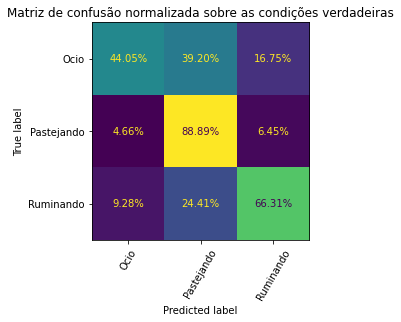

In [261]:
imprimeMatrizDeConfusão(y_test, preds, model)

### Gradient Boosting

In [122]:
from xgboost import XGBClassifier

In [123]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_train_ordinal = ordinal_encoder.fit_transform(y_train.array.reshape(-1,1))
y_test_ordinal = ordinal_encoder.transform(y_test.array.reshape(-1,1))

In [109]:
xgb_model = XGBClassifier(use_label_encoder=False, random_state=0)
xgb_model.fit(X_train, y_train_ordinal)

[16:42:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [110]:
xgb_preds = xgb_model.predict(X_test)
xgb_preds = ordinal_encoder.inverse_transform(xgb_preds.reshape(-1,1))
accuracy_score(y_test, xgb_preds)*100

71.71539158362843

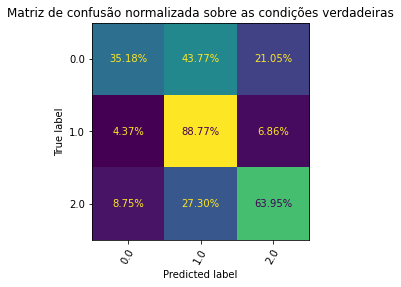

In [111]:
imprimeMatrizDeConfusão(y_test, xgb_preds, xgb_model)

#### GB: Busca de melhores hiper parâmetros

In [112]:
def tune_gb(params):
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight = params[2]
    gamma = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    gb_Model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree,
                             use_label_encoder=False, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(gb_Model, X_train, y_train_ordinal, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 16), # max_depth
         (1, 16), # min_child_weight
         (0.0, 0.5), # gamma
         (0.1, 1.0)] # colsample bytree

In [ ]:
%%time
resultados_gb = gp_minimize(tune_gb, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 14, 14, 0.4236258693920628, 0.6612073271073752] 

[16:43:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 244.4441
Function value obtained: -0.7

In [ ]:
resultados_gb.x

[0.1, 16, 1, 0.0, 0.5370264280766771]

In [ ]:
# Melhores hiper parâmetros para o conjunto PRO: learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

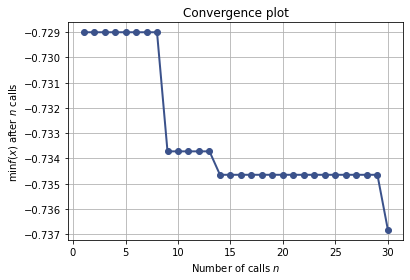

In [117]:
from skopt.plots import plot_convergence
plot_convergence(resultados_gb)

In [87]:
# Melhores hiper parâmetros para o conjunto PNP: learning_rate=0.008851671496973969, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.631278076735511, use_label_encoder=False, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

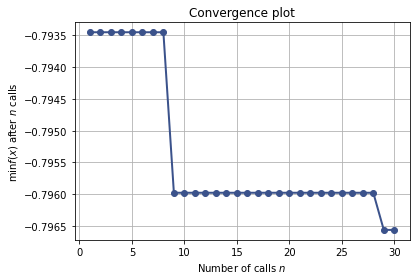

In [85]:
plot_convergence(resultados_gb)

#### GB: Treinamento com os melhores hiper parâmetros

In [124]:
%%time
gb_model = XGBClassifier(learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1)

gb_model.fit(X_train, y_train_ordinal)
preds = gb_model.predict(X_test)

[11:35:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 18min 16s, sys: 13.7 s, total: 18min 30s
Wall time: 2min 32s


In [125]:
preds = ordinal_encoder.inverse_transform(preds.reshape(-1,1))
accuracy_score(y_test, preds)*100

74.29218479782591

In [126]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.657     0.429     0.519     24652
  Pastejando      0.775     0.894     0.830     66502
   Ruminando      0.705     0.667     0.686     30276

    accuracy                          0.743    121430
   macro avg      0.713     0.663     0.678    121430
weighted avg      0.734     0.743     0.731    121430



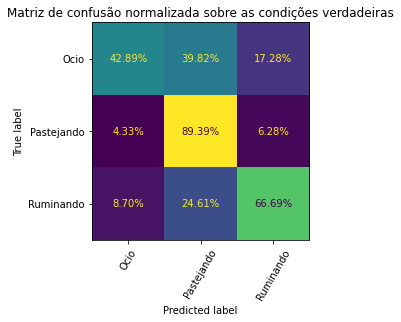

In [127]:
imprimeMatrizDeConfusão(y_test, preds, model)

### SVM

In [21]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state = 0)

In [ ]:
%%time
svc_model = SVC(kernel='linear', cache_size=5000, random_state=0) # Linear Kernel

svc_model.fit(X_train, y_train)

svc_preds = svc_model.predict(X_test)

In [ ]:
print("Acurácia:", accuracy_score(y_test, svc_preds))

###  Gaussian Naive Bayes

In [105]:
# Conjunto com todas as classes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [106]:
from sklearn.naive_bayes import GaussianNB

In [107]:
gnb_model = GaussianNB()
gnb_preds = gnb_model.fit(X_train, y_train).predict(X_test)
print("Acurácia:", accuracy_score(y_test, gnb_preds))

Acurácia: 0.5575803093788705


### Logistic Regression

In [114]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Agua', 'Locomovendo', 'Ocio', 'Outros','Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y_pnp, random_state = 0)

In [118]:
from sklearn.linear_model import LogisticRegression

In [128]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [129]:
lr_preds = lr_model.predict(X_test)

In [130]:
print("Acurácia:", accuracy_score(y_test, lr_preds))

Acurácia: 0.6313740216617915


### Redes Neurais

In [131]:
from sklearn.neural_network import MLPClassifier

In [29]:
rn_model = MLPClassifier(early_stopping=False, max_iter=400, verbose=True, random_state=0)
rn_model.fit(X_train, y_train.values)

Iteration 1, loss = 0.84517620
Iteration 2, loss = 0.78654388
Iteration 3, loss = 0.77102238
Iteration 4, loss = 0.76345618
Iteration 5, loss = 0.75809004
Iteration 6, loss = 0.75408986
Iteration 7, loss = 0.75090710
Iteration 8, loss = 0.74821197
Iteration 9, loss = 0.74620358
Iteration 10, loss = 0.74471362
Iteration 11, loss = 0.74336294
Iteration 12, loss = 0.74201381
Iteration 13, loss = 0.74091084
Iteration 14, loss = 0.73981006
Iteration 15, loss = 0.73910366
Iteration 16, loss = 0.73789275
Iteration 17, loss = 0.73749282
Iteration 18, loss = 0.73665872
Iteration 19, loss = 0.73590588
Iteration 20, loss = 0.73543882
Iteration 21, loss = 0.73468720
Iteration 22, loss = 0.73442992
Iteration 23, loss = 0.73369323
Iteration 24, loss = 0.73326292
Iteration 25, loss = 0.73313289
Iteration 26, loss = 0.73285653
Iteration 27, loss = 0.73190634
Iteration 28, loss = 0.73186538
Iteration 29, loss = 0.73169249
Iteration 30, loss = 0.73127796
Iteration 31, loss = 0.73081542
Iteration 32, los

MLPClassifier(max_iter=400, random_state=0, verbose=True)

In [58]:
rn_preds = rn_model.predict(X_test)

In [59]:
print("Acurácia:", accuracy_score(y_test, rn_preds)*100)

Acurácia: 69.84873639549899


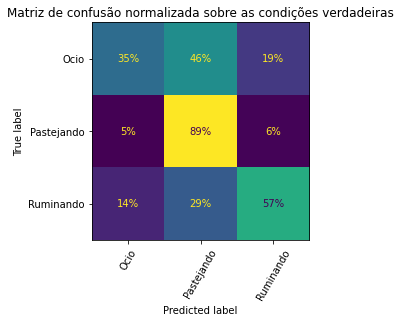

In [33]:
imprimeMatrizDeConfusão(y_test, rn_preds, rn_model)

#### RN: Busca de melhores hiper parâmetros 

### KNN

In [106]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
knn_model = KNeighborsClassifier(n_neighbors=10,  weights='distance', n_jobs=-1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')

In [29]:
knn_preds = knn_model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, knn_preds))

Acurácia: 0.7379230832578441


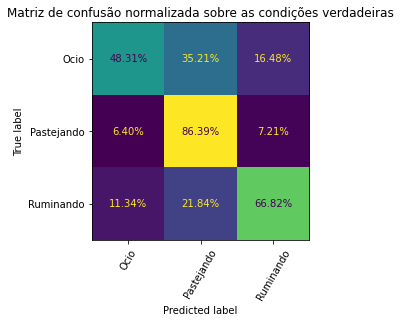

In [30]:
imprimeMatrizDeConfusão(y_test, knn_preds, knn_model)

#### KNN: Busca de melhores hiper parâmetros

In [56]:
def tune_knn(params):
    n_neighbors = params[0]
    weights = params[1]
    leaf_size = params[2]
    p = params[3]
    
    print(params, '\n')
    
    knn_Model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size, p=p, n_jobs=-1)
    
    knn_Model.fit(X_train, y_train)
    
    preds = knn_Model.predict(X_test)
    
    return -accuracy_score(y_test, preds)

space = [(5, 50), #n_neighbors
         ['uniform', 'distance'], # weights
         [20,30,40,50,100], # leaf_size
         [1,2]] # p

In [ ]:
%%time
resultados_knn = gp_minimize(tune_knn, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

In [58]:
resultados_knn.x

[50, 'distance', 20, 2]

In [59]:
# Melhores hiper parâmetros para o conjunto PRO: n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

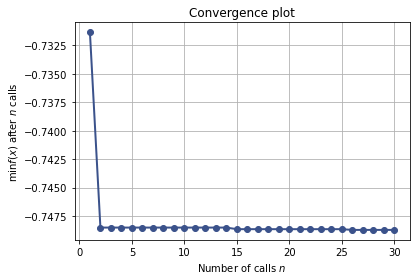

In [52]:
from skopt.plots import plot_convergence
plot_convergence(resultados_knn)

In [97]:
# Melhores hiper parâmetros para o conjunto PNP: n_neighbors=46, weights='distance', leaf_size=20, p=2, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

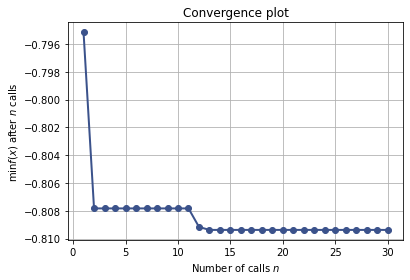

In [60]:
from skopt.plots import plot_convergence
plot_convergence(resultados_knn)

#### KNN: Treinamento com os melhores hiper parâmetros

In [229]:
%%time
knn_model = KNeighborsClassifier(n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1)

knn_model.fit(X_train, y_train)
preds = knn_model.predict(X_test)

CPU times: user 1min, sys: 124 ms, total: 1min
Wall time: 9.74 s


In [230]:
accuracy_score(y_test, preds)*100

74.64053364078069

In [231]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.643     0.465     0.540     24652
  Pastejando      0.789     0.879     0.832     66502
   Ruminando      0.701     0.683     0.692     30276

    accuracy                          0.746    121430
   macro avg      0.711     0.676     0.688    121430
weighted avg      0.738     0.746     0.738    121430



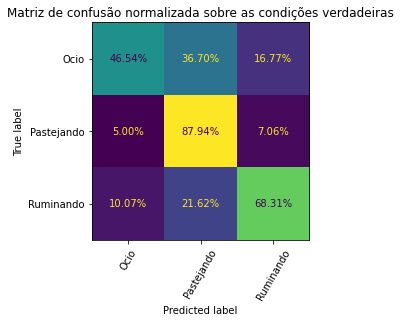

In [232]:
imprimeMatrizDeConfusão(y_test, preds, model)

### Leave One Group Out

In [59]:
from sklearn.model_selection import LeaveOneGroupOut
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [60]:
from sklearn.model_selection import cross_validate

In [61]:
# PRO
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, 
                           colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)

rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=None, 
                                  criterion='entropy', min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1)

knn_model = KNeighborsClassifier(n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1)

xgb_model = XGBClassifier(learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1)

models = [lgb_model, rf_model, knn_model, xgb_model]

In [62]:
def executarLogo(models, groups, X, y):
    logo = LeaveOneGroupOut()
    for model in models:
        cv = logo.split(X, y, groups)
        resultado = cross_validate(model, X, y, cv=cv, n_jobs=-1, return_estimator=True)
        print(resultado['estimator'][0], '-> Acurácia: ' , resultado['test_score'].mean()*100, '% Tempo de treino: ',
             resultado['fit_time'].sum())

In [63]:
df = pd.read_csv(caminho_dados_lazaro)

In [64]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

In [65]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [66]:
y = df.Comportamento
X = df[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]

In [22]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y = y.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')

In [67]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_season = X[['Season_fall', 'Season_spring', 'Season_summer']]

X = X.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)

columns = X.columns
index= X.index

sc = StandardScaler()
X = sc.fit_transform(X)

X = pd.DataFrame(X, columns=columns, index=index)

X = pd.concat([X, X_season], axis=1)

#### Leave Fall Out

In [68]:
groups = np.array(X.Season_fall.values)

In [69]:
lfo = LeaveOneGroupOut()
lfo.get_n_splits(X, y, groups)

2

In [70]:
cv = lfo.split(X, y, groups)

In [71]:
executarLogo(models, groups, X, y)

LGBMClassifier(colsample_bytree=0.662, min_child_samples=1, num_leaves=512,
               random_state=0, subsample_freq=1) -> Acurácia:  56.05743227758413 % Tempo de treino:  18.151487588882446
RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=0) -> Acurácia:  55.42669762180896 % Tempo de treino:  134.24050283432007
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=37, p=1,
                     weights='distance') -> Acurácia:  55.052964369606826 % Tempo de treino:  2.244258165359497
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5370264280766771,
              enable_categorical=False, gamma=0.0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=16,
              m

/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 2.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/caio/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/home/caio/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1199, in fit
    raise ValueError(label_encoding_check_error)
ValueError: The label must consist of

#### Leave Summer Out

In [16]:
groups = np.array(X.Season_summer.values)

In [17]:
executarLogo(models, groups, X, y)

LGBMClassifier(colsample_bytree=0.662, min_child_samples=1, num_leaves=512,
               random_state=0, subsample_freq=1) -> Acurácia:  54.337711081503606 % Tempo de treino:  18.035350799560547
RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=0) -> Acurácia:  55.26477692106604 % Tempo de treino:  127.01389050483704
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=37, p=1,
                     weights='distance') -> Acurácia:  55.48080606209784 % Tempo de treino:  2.536006450653076


#### Leave Spring Out

In [18]:
groups = np.array(X.Season_spring.values)

In [19]:
executarLogo(models, groups, X, y)

LGBMClassifier(colsample_bytree=0.662, min_child_samples=1, num_leaves=512,
               random_state=0, subsample_freq=1) -> Acurácia:  48.25692393014705 % Tempo de treino:  18.14651083946228
RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=0) -> Acurácia:  47.55713543423377 % Tempo de treino:  105.31440734863281
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=37, p=1,
                     weights='distance') -> Acurácia:  47.191413536152325 % Tempo de treino:  2.904277801513672


#### Leave One Animal Out

In [53]:
groups = np.array(df.Animal.values)
models = [lgb_model, knn_model, xgb_model]

In [54]:
executarLogo(models, groups, X, y)

LGBMClassifier(colsample_bytree=0.662, min_child_samples=1, num_leaves=512,
               random_state=0, subsample_freq=1) -> Acurácia:  52.48896328774799 % Tempo de treino:  245.83199048042297
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=37, p=1,
                     weights='distance') -> Acurácia:  51.295960765708756 % Tempo de treino:  43.223567962646484
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5370264280766771,
              enable_categorical=False, gamma=0.0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_metho

/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
8 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/caio/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/home/caio/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1199, in fit
    raise ValueError(label_encoding_check_error)
ValueError: The label must consist of

In [70]:
df = df[features_aplicaveis]

y = df.Comportamento
X = df.drop('Comportamento', axis=1)

X = np.array(X)
y = np.array(y)

In [73]:
cv = loao.split(X, y, groups)

In [74]:
%%time
scores = cross_val_score(model, X, y, cv=cv)

CPU times: user 28.5 s, sys: 2.23 s, total: 30.7 s
Wall time: 10min 52s


In [75]:
scores.mean()

0.5223208141879215

##### Vizualização

In [26]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
y = enc.fit_transform(y.array.reshape(-1, 1))

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

np.random.seed(0)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

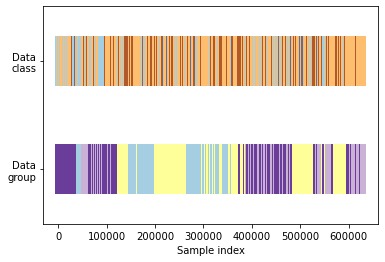

In [108]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")

### Validação Exeterna com os dados do Leonardo

Leitura dos bancos de dados em DataFrame Pandas. 

In [262]:
caminho_dados_leo = 'Datasets/Leonardo/dados_pre_processados_leonardo.csv'

In [263]:
df_leo = pd.read_csv(caminho_dados_leo)

In [264]:
df_leo.head()

,SensorID,Date,Value,Voltage,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer,magn,sma,ent,erg,pit,rol,icl
0,175810,2019-01-21 08:15:03,1.115,3.04,-0.171,1.115,0.242,Pastejando,0,0,1,1.153703,1.528,7.474426,1.771641,-12.108253,-8.719130,-81.476304
1,175810,2019-01-21 08:16:04,0.583,3.02,-0.702,0.071,0.583,Pastejando,0,0,1,0.915278,1.356,-0.089163,0.701798,-39.565868,-84.224766,-39.916535
2,175810,2019-01-21 08:16:05,0.683,3.01,-0.594,-0.026,0.683,Pastejando,0,0,1,0.905539,1.303,0.138071,0.672402,-48.959606,-92.506296,-49.007300
3,175810,2019-01-21 08:16:06,0.631,3.01,-0.706,0.059,0.631,Pastejando,0,0,1,0.948724,1.396,-0.031235,0.810140,-41.690272,-85.222926,-41.913249
4,175810,2019-01-21 08:16:07,0.604,3.01,-0.805,0.081,0.604,Pastejando,0,0,1,1.009654,1.490,-0.197988,1.039180,-36.742843,-84.254174,-37.126721


In [265]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df_leo = df_leo[features_aplicaveis]

In [266]:
df_leo = df_leo.rename({'X': 'a', 'Y': 'b', 'Z': 'c'}, axis=1)  

In [267]:
df_leo = df.rename({'a': 'Y', 'b': 'Z', 'c': 'X'}, axis=1)  

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [268]:
# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
y = df_leo.Comportamento
X = df_leo.drop('Comportamento', axis=1)

In [40]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')

In [269]:
# Para reescalar os dados
X_season = X[['Season_fall', 'Season_spring', 'Season_summer']]

X.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X.columns
index = X.index

X = sc.transform(X)

X = pd.DataFrame(X, columns=columns, index=index)

X = pd.concat([X, X_season], axis=1)

#### Com LGBMClassifier

In [199]:
%%time
lgb_preds = lgb_model.predict(X)

accuracy_score(y, lgb_preds)*100

CPU times: user 21.2 s, sys: 55.8 ms, total: 21.2 s
Wall time: 3.17 s


76.29300831754921

In [201]:
print(classification_report(y, lgb_preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.711     0.446     0.548    123257
  Pastejando      0.786     0.911     0.844    332512
   Ruminando      0.729     0.695     0.712    151381

    accuracy                          0.763    607150
   macro avg      0.742     0.684     0.701    607150
weighted avg      0.757     0.763     0.751    607150



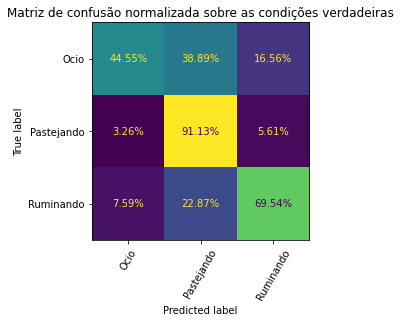

In [203]:
imprimeMatrizDeConfusão(y, lgb_preds, lgb_model)

#### Com RF

In [270]:
%%time
preds = rf_model.predict(X)

CPU times: user 27.9 s, sys: 72 ms, total: 27.9 s
Wall time: 3.69 s


In [271]:
accuracy_score(y, preds)*100

86.06077575557934

In [272]:
print(classification_report(y, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.874     0.673     0.761    123257
  Pastejando      0.860     0.951     0.903    332512
   Ruminando      0.853     0.815     0.834    151381

    accuracy                          0.861    607150
   macro avg      0.863     0.813     0.833    607150
weighted avg      0.861     0.861     0.857    607150



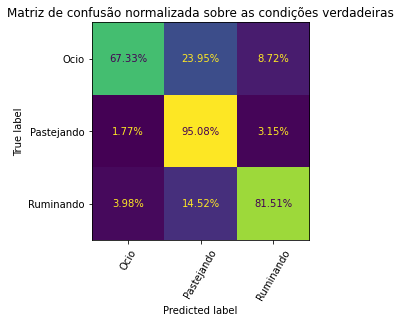

In [273]:
imprimeMatrizDeConfusão(y, preds, rf_model)

#### Com Gradient Boosting

In [208]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_ordinal = ordinal_encoder.fit_transform(y.array.reshape(-1,1))

In [209]:
%%time
preds = gb_model.predict(X)

CPU times: user 38.5 s, sys: 122 ms, total: 38.7 s
Wall time: 5.18 s


In [210]:
preds = ordinal_encoder.inverse_transform(preds.reshape(-1,1))
accuracy_score(y, preds)*100

87.05377583793131

In [211]:
print(classification_report(y, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.884     0.686     0.773    123257
  Pastejando      0.875     0.951     0.912    332512
   Ruminando      0.851     0.843     0.847    151381

    accuracy                          0.871    607150
   macro avg      0.870     0.827     0.844    607150
weighted avg      0.871     0.871     0.867    607150



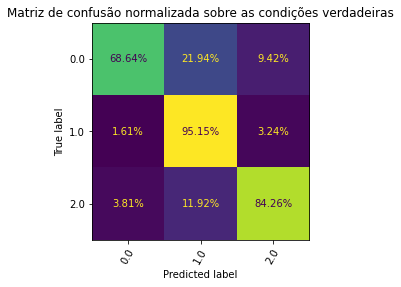

In [212]:
imprimeMatrizDeConfusão(y, preds, gb_model)

#### Com KNN

In [243]:
%%time

preds = knn_model.predict(X)

CPU times: user 14min 17s, sys: 2.12 s, total: 14min 19s
Wall time: 1min 53s


In [244]:
accuracy_score(y, preds)*100

94.92036564275715

In [245]:
print(classification_report(y, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.945     0.893     0.918    123257
  Pastejando      0.954     0.976     0.965    332512
   Ruminando      0.941     0.936     0.939    151381

    accuracy                          0.949    607150
   macro avg      0.947     0.935     0.941    607150
weighted avg      0.949     0.949     0.949    607150



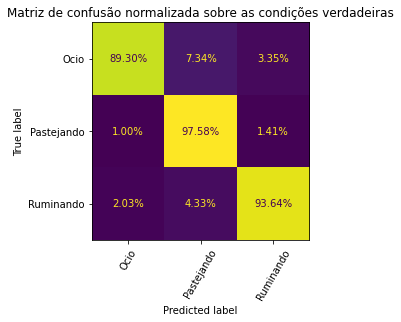

In [246]:
imprimeMatrizDeConfusão(y, preds, knn_model)

### Teste de RF em CV

In [22]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    clf = RandomForestClassifier(n_estimators, random_state=0, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=3)
    return scores.mean()


In [14]:
results = {} 
n_estimators = 100
while n_estimators < 250:
    n_estimators += 50
    results[n_estimators] = get_score(n_estimators)

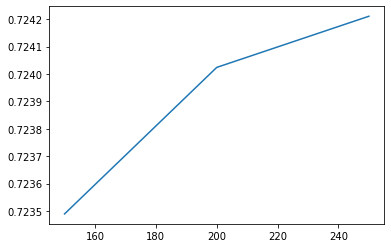

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

### Lidando com dados desbalanceados

In [149]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns

In [150]:
df.Comportamento.value_counts()

Pastejando    332512
Ruminando     151381
Ocio          123257
Name: Comportamento, dtype: int64

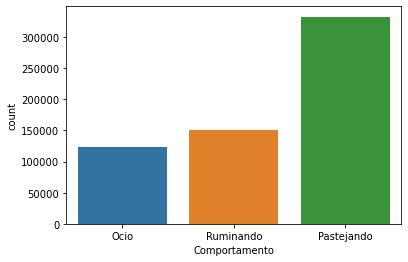

In [151]:
ax = sns.countplot(x="Comportamento", data=df)

In [152]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [153]:
accuracy_score(y_test, preds)*100

74.16462434448046

In [156]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.65      0.43      0.52     30838
  Pastejando       0.78      0.89      0.83     83380
   Ruminando       0.70      0.67      0.68     37570

    accuracy                           0.74    151788
   macro avg       0.71      0.66      0.68    151788
weighted avg       0.73      0.74      0.73    151788



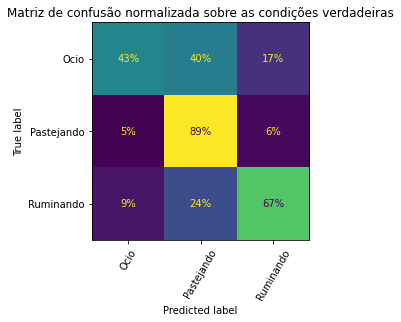

In [157]:
imprimeMatrizDeConfusão(y_test, preds, model)

#### Aplicando NearMiss

In [164]:
nr = NearMiss()

In [165]:
X, y = nr.fit_resample(X, y)

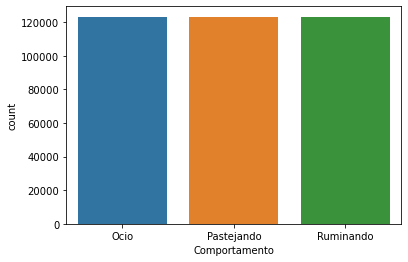

In [166]:
ax = sns.countplot(x=y)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [168]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [169]:
accuracy_score(y_test, preds)*100

68.94086085479701

In [170]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.66      0.61      0.64     30976
  Pastejando       0.70      0.73      0.72     30906
   Ruminando       0.70      0.73      0.72     30561

    accuracy                           0.69     92443
   macro avg       0.69      0.69      0.69     92443
weighted avg       0.69      0.69      0.69     92443



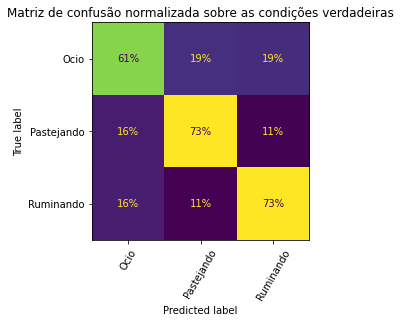

In [171]:
imprimeMatrizDeConfusão(y_test, preds, model)

#### Aplicando o SMOTE

In [78]:
X = df.drop("Comportamento", axis = 1)
y = df.Comportamento

In [79]:
# Visualizando a quantidade de dados por classe
y.value_counts()

Pastejando    332512
Ruminando     151381
Ocio          123257
Name: Comportamento, dtype: int64

In [80]:
smt = SMOTE()

In [81]:
X, y = smt.fit_resample(X, y)

In [60]:
# Visualizando a quantidade de dados por classe
y.value_counts()

Ocio          332512
Ruminando     332512
Pastejando    332512
Name: Comportamento, dtype: int64

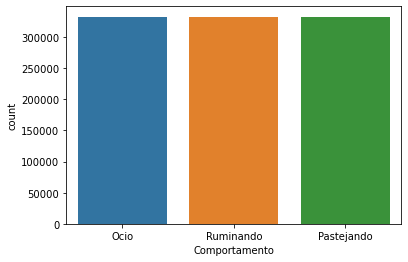

In [63]:
ax = sns.countplot(x=y)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [65]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [66]:
accuracy_score(y_test, preds)*100

76.60595707824078

In [67]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.76      0.72      0.74     83256
  Pastejando       0.75      0.80      0.77     83127
   Ruminando       0.79      0.78      0.78     83001

    accuracy                           0.77    249384
   macro avg       0.77      0.77      0.77    249384
weighted avg       0.77      0.77      0.77    249384



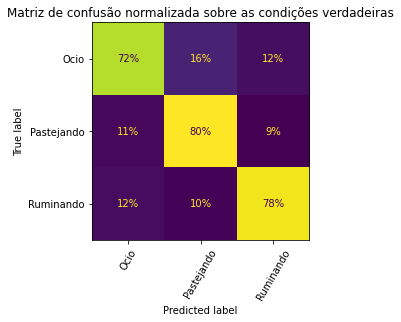

In [69]:
imprimeMatrizDeConfusão(y_test, preds, model)